# Direct spectrum estimation of speech signal

## Load packages and functions

In [18]:
using LinearAlgebra
using Plots
using PyPlot
using ProgressMeter
using Compat
using WAV
using Base64
using FileIO
using HDF5
using FLAC
using DSP
using FFTW
using Turing
using StatsPlots

include("../functions/auxiliary/buffer.jl")
include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
include("../functions/auxiliary/warpedfilter.jl")
;

## Adjustable parameters

In [41]:
# signal preprocessing
sound_file = "../data/woman.wav"      # specify sound location
fs_desired = 4000                        # specify desired sampling frequency

# inference and modelling
AR_order = 2                            # order of auto-regressive model
iterations = 3                           # number of iterations for variational message passing
Λ_meas = 1e6                            # assumed precision of measurement noise
;

## Load data

In [43]:
# load and process speech signal
x_time, fs_time = wavread(sound_file, format="native")
fs_time = Int(fs_time)
x_time = x_time[1*fs_time+1:2*fs_time]
x_time = resample(x_time, fs_desired/fs_time)
x_time = 100*x_time/var(x_time)

# specify time axis
t = collect((1:length(x_time))/fs_desired)

# create audioplayer
audioplayers(x_time, fs=fs_desired)
;

<source src="data:audio/wav;base64,UklGRrw+AABXQVZFZm10ICgAAAD+/wEAoA8AAIA+AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YYA+AACO0x6+BsFfvo5Yqr0SX7E9bWCnPmT93j4Escs+yWxiPUxhrb3P/p6+u2EqvuZpSb0Zsno9QWMqPV1Vv71guxW+m1d+viIcFL5elJW9BzdSPo6etz5G6fQ+mhiFPuK5brx3+ku+Gc+mvp3Avr2dHUq9VxrwPS/2xTqwR4a9WYVRvn28Wb523yC+NjqxPVfioz4pPPo+h+awPmSMHz3hEiO+KqvCvoP2H74pvve9nG4bPjYa8zzg9TM9uT4qvkYMUr5qRkC+b/3Cu4aeiz7s/NQ+SXDVPk9MaT3ltpK9pgbIvit0XL5aoTW+/ItmPUJ0Zj1rvNA8vRRYvTU/Kr4Jc369p3awPSiI2D7NaLo+jdQzPkp7mb2Poaq+w/V6vpl+T7647rs9a5H0PaDy3D07pR68U+RSvrbnS75DeVK+JrQXPYTJIj4yI5s+WmdgPlhM6D0ggx69zzXBvTk8Or44zvO9pNzOvSYMOzxTEoK9TlejvEPnDL0JUwc+eSaQPkO73T46mAA+hADnO2BJob701HC+T+dUvg9S4jzSHS0+Nsg+Pqg2Hz5EVaK96rQCvq+0c76FBc69ERVwvQkOhj3xwUw9lv0kPdmnMb0HmkW9rI4yvQDJBL2ngBQ8YfFpuyWCFzzG2Q29csW2vP/hHLwFJhw9WfZVPdZ4nT3YAik9Zs+uPIR/E73mPoG93nKrvaT5kL3NClm9u5TwvBHj9ruht5M8maSAPaU3sT0RE/Y9YAqoPYBNEj0UnWS9/YAJvkSPHb6Okxm+u1qrvWmbEb0pAMA8Je5mPfj03z29y04+VftXPhDRCD49GtC8knsxvgZac76dEW++T7AJvrs2Yr2fqT09esmzPUVQFD5ao1c++V6MPskhsj1Ii7M8eow2vqP2Fr6VAT2+qJA3vYkUIzzXm9U9VZygPYw8ED0wz069bKuwvRmN7b0u5qW9DVIfvT8DeryNtXo6x8SwO805HLtV6VS7xkWqu0X+fryu4Yy8QwSUu/Uk8TuOzCI8iSEVPd+3+zyC/Oc8SbrePI8NozyZPBc7PdQcvNdoN7zVyEe8AF2Tuw263jn7Vi080RePPBThtzzz2K4896SAPGaK1TwrpNS6eKJoPFHCzruYnKM7WQBwOjAdMzr4MQM8UB43O8oyYTyD18Q7bRl4PEWQVzwvd408lza8POKQvTvpVZQ8paslvO5y5bveg0K8bCqVO5/ZmbzGJ1M8Kzo+vN0Bs7uN4aM7AlOOvJBeBjyR+KO8A4McvMpKwrxF89+8nRmIvKAcxLyXRBi7Am3JvBKMBrsHnqO8GdYUvOeta7w1XJC8bYeWvGiSqLx7ULO8jIcvvCAY3rvip2m7R1ylutuLeLtq05K7+P2eu9SHL7yW6LG6wB4guWYqKTuQWWu7XBQgvKjuSbyKHXu8pVh3vJs3t7v6qLU683ElPPTUqTvGFMI7/WmhtnM7qTmJb0+78vatui1ctLp7Cxu8zr4ovOEjKrzzxxw72V4EOhi46zsQryI7UP9xO1id47iXBWY7Hw4HO7A4UjuIXB08aro+PHpqPTw6ihI8chqzOxlChztthjA89LIFPCQp+TsSD+Y7mi8sPFBvxTvOiBc8vBVwPL+CRzy7LQA8YSuHO7TKxrsz0xW8i1KquxHz+joBfoo6fPrVOGiMG7yQCk28bAqWvCzCrrxPrKu8qsuVvFo+pry32rC8czrSvF5B0rz9X9a8dRa0vCfHlLyIpI+8SFiIvM8x0byh6K28HtShvMb3mrz5irC8jcKQvObDibyVxGK8a60LvPFFQrxzvQa8XPTGu8pq1bvEDwG7Eh5CubV03jpOTRA7DmwWu8HtFrvulLg6tf1/O1inzTsZUyE8nclkPGIwRzwqESA8j8w8PEPzFzyTmhw8FG9JPNeGYzze6Dw8c/dnPAgblzwTvoI8dj6hPIroVTxr6Js8PRxTPP5hfzz2TnE8xHFbPCOMVzxwxAE8E5IHPOTPGjyaCRc8Fl/3O+/I6TsGsX87AnngO2c+gDu8vDY847VFPLO/dTygn3E8pTsYPELeXTxG5CM8BRpRPBOAOzzBkIQ87G2TPCsfiTxE+4s85p0rPE/MhDyos4c81vJmPHRlTjyxXfA7WFcYPLZVFTsl5m84zVxqurEj4rrqlAw6OFk7uzcL8LoJ8UA7JC2XOxkVAzsFTxo7L3hNuRM1bLu14PC7Qmn7uyQBr7vENlW60ycWuezQwjjvLSI64UyCu9z4m7vyUNq7/UWruz/j1LsG6aK74LLau+wyQLyB9Rm8rWIqvB+JKbxA3Sy8a68YvAnSAbzoCQe8HKoFvCcnC7w2V2u7a7cCvC5+xrt7tuK7q58nu69q4bspwbe7UEtAvC/Tubu7wrO73X+lu1qoyrssNci7N6IrvInX/rtPnxK8OkoRvCSCrLvKUeG7PpJ7uzJLs7tIyuC7QADlu9TQH7ynegK87F8OvMVJMLy7sBu80WJru15tVzuaFUe7ozjOuqA9R7sBdsG7aomPuzp0ibtnwBy7oeKJO4ewYDs/G3i47RS+OvJtpjseOJQ7d/CbO/cctDuuG9s73mxnO9k/ubom3Va7C9QbuxKYcbsvdOW77xckOwvvlDqPcSa7eXS5ukyvVbrZlSk7f7Phuk/yrTrnaE85uZkSu6qSEruupue6EMtUuhbi87rvCtw5batKutIa2rvsH727oc2Wu9G2qLu5puu60E7EuvpISjuNw5w76f2lOUwnxDmRHMC7awuzOjW0jjukz5w74687PFtgLTy9VhE8cE+KO47iDjtBkns7u+SGO/OLVLqGIrG7ZVMRu6wgAboR6+o6GmPzuWrhAbsYHCY7cSaLuwVCazoIXp27t9wUuiTbDbpeN/648+7dOYkpvrpqiRm77Wr2ug2M1Lq4ehS7TDWtujAhtrrgqda4sUhgur70BbvB4Zq7XzlEu7AMirvaic67DNq/u7lcKbvuGYa7hi46u9yEMrzPjx2823/CuyeM8rusDJ27nRu8OpG1UTszUZi6MF3Ou+CM9rsTmJG70pzBOWJRfrv66zi7zTBru4LOrjvV9J06eyqWOmiiPDtYN7g7xvuNO6FEljt5alg79Qe8OwB3nDoRdu86RV4ROxhRfjtbAhY8XfoEPLXEEjw5Fbk7Y7XmOtoe/jv9LR47o574O3qb6Lraa4M7Lro5vJmEtDpEkDm8IvmuvfmR5bvCLFK9TZO+vDuZAL4lgH69zAuNPSC9zL1xCwu+ld1lvcquUzwCQ5M8noyfvTkInDyoecy8VWeHPI+YKb2jNQY9hR+yvN2ZfT00DMK91wKvPSxCc70OCqY9+6T5vM16tD2HNz884FqkPZJHnjy15iM9mrcCPXJ3Gj3a03c8/GCCPVkNezs3NrM9YB8tvJnx/jyFo4q6sjH5PIsJsjyQAMM8d3EgPUb4Lbyr6oo9HRyqu6hTYT08/we9DBOOPWfVVr3riYE9LIBDvS0Ijz1zSKI7bozcPBbJ9DuO27I6x0TfPJC5h7yuFiE96uztvH7WNT1NFh29HMvfPK8RKL1fwsk82QU4PEJhGTxkw5A88kYnPC/hbTwn0QE8bopBvJ1gxDxbSzQ8l45HPC+ie7zVH188o2aIvJTJBjy/HO+8+sj3PL0rI722uw89JsZCvamfJT2DwBm9vzMDPWRRjby3+qu7QWssPNBTkrzUnuM89Qq8vMpTBj1ETBu9hJSAPUaQ3byGE1g915g4vc4agD2Ix5a9uYmcPULVgr1gf9g9zoNWvSlI5z358JC9zCXiPc+CiL20ieM9uAsxvVD8iD0FpE+7kUWZO5CE+j0ejJa9Hgo2PhBXCL6fL1c+3fMKvk5Q4D08C6S86KqiPHIN2D25K3u9txTAPciPir395

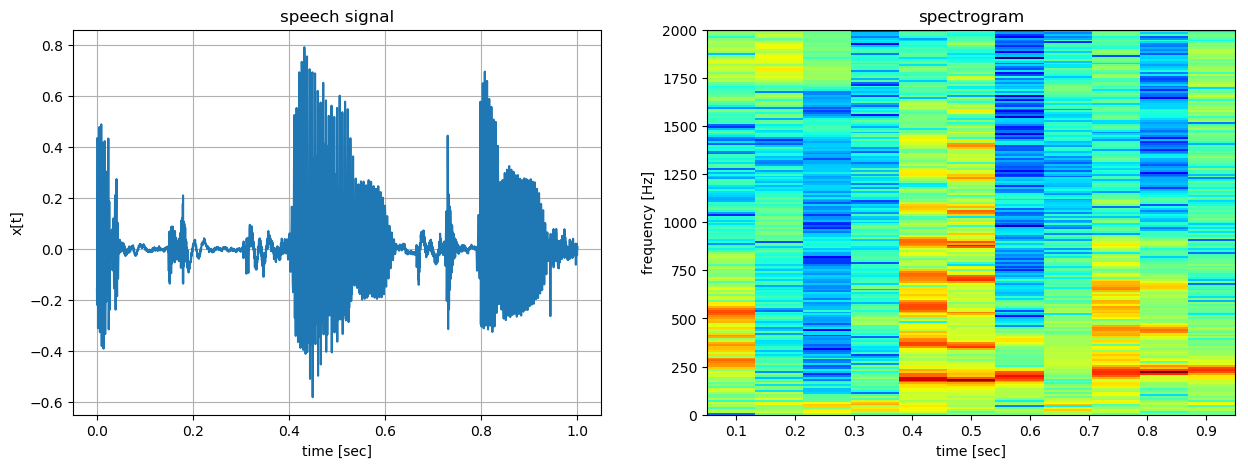

In [44]:
# create figure with subplots
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
ax[1].plot(t, x_time)

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_time, convert(Int, 100e-3*fs_desired), convert(Int, 10e-3*fs_desired), fs=fs_desired), fs_desired, ax=ax[2])

# visual modifications
ax[1].grid(), ax[1].set_ylabel("x[t]"), ax[1].set_xlabel("time [sec]"), ax[1].set_title("speech signal"), ax[2].set_title("spectrogram")
;

## Generative model

In [109]:
@model AR_model(x, AR_order, Λ_meas) = begin
    
    θ1 ~ Normal()
    θ2 ~ Normal()
    
    σ0 ~ InverseGamma(2,3)
    σθ ~ InverseGamma(2,3)
    
    xθ = Vector(undef, length(x))
    xtot = Vector(undef, length(x))
    x0 ~ Normal(0, sqrt(σ0))
    
    z = Vector(undef, 30)
    ϕ = [0.5, 0.5]
    for zn = 1:30
        z[zn] ~ Bernoulli()
    end
    
    xθ[1] ~ Normal()
    xθ[2] ~ Normal()
    
    for n = 3:length(x)
        xθ[n] ~ Normal(θ1*xθ[n-1] + θ2*xθ[n-2], sqrt(σθ))
        xtot[n] = [xθ[n], x0]
        x[n] ~ Normal(xtot[n][z[Int(ceil(n*30/length(x)))]], 1/sqrt(Λ_meas))
    end
    
end

##AR_model#3515 (generic function with 2 methods)

## Algorithm generation

In [110]:
# Settings of the Hamiltonian Monte Carlo (HMC) sampler.
iterations = 10
ϵ = 0.05
τ = 10

#sampler = HMC(ϵ, τ)
#sampler = NUTS(200, 0.6)
sampler = Gibbs(PG(10, :z), HMC(0.1, 5))


# Start sampling.
chain = sample(AR_model(x_time, AR_order, Λ_meas), sampler, iterations);

ArgumentError: ArgumentError: invalid index: true of type Bool

In [39]:
describe(chain)

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters                                                                                                                         mean                                                                                                           std  naive_se     mcse     ess   r_hat
  ──────────  ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────  ────────────────────────────────────────────────────────────────────────────────────────────────────────────  ────────  ───────  ──────  ──────
        p[1]                                                                                                                       0.1718                                                                                                        0.0000    0.0000  missing  3.3333     Inf
        p[2]                                                                                     

## Predictions

In [7]:
# create figure 
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot prediction of frequency component
ax[1].plot(t, μ_x_pred, label="prediction"), ax[2].plot(t, μ_x_pred, label="prediction")
ax[2].fill_between(t, μ_x_pred .- sqrt.(var_x_pred), μ_x_pred .+ sqrt.(var_x_pred), alpha=0.3)

# plot true evolution of frequency component # add offset because prediction is only performed for second sample forwards
ax[1].plot(t, x_time, label="true"), ax[2].plot(t, x_time, label="true") 

# change visualization
ax[1].legend(), ax[1].grid(), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("signal"), ax[1].set_title("entire evolution of signal"), ax[1].set_xlim(0, 3)
ax[2].legend(), ax[2].grid(), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("signal"), ax[2].set_title("part of evolution of signal")
ax[2].set_xlim(0.8, 0.81), ax[2].set_ylim(-0.25,0.25), ax[1].set_ylim(-0.25, 0.25)

audioplayers(x_time, μ_x_pred, fs=fs_desired)
;

UndefVarError: UndefVarError: μ_x_pred not defined

## Visualize parameters

In [8]:
# loop through auto-regressive coefficients
for ki = 1:AR_order
    
    # plot auto-regressive coefficients
    plt.plot(t, [μ_θ_mem[k][ki] for k=1:length(μ_θ_mem)])
    
    plt.fill_between(t, [μ_θ_mem[k][ki] for k=1:length(μ_θ_mem)] .- sqrt.([1/Λ_θ_mem[k][ki,ki] for k=1:length(μ_θ_mem)]), [μ_θ_mem[k][ki] for k=1:length(μ_θ_mem)] .+ sqrt.([1/Λ_θ_mem[k][ki,ki] for k=1:length(μ_θ_mem)]), alpha=0.3)
    
end

# change visualization
plt.grid(), plt.ylim(-0.75, 0.75), plt.xlim(0, 3), plt.xlabel("time [sec]"), plt.ylabel("auto-regressive coefficients θ"), plt.title("Evolution of auto-regressive coefficients")
;

UndefVarError: UndefVarError: μ_θ_mem not defined

In [9]:
_, ax = plt.subplots(ncols=2, figsize=(15,4))
ax[1].plot(t, [(a_γ_mem[k]-1)/b_γ_mem[k] for k = 1:length(a_γ_mem)])
ax[2].plot(t, [10*log10.(b_γ_mem[k]^2/a_γ_mem[k]) for k = 1:length(a_γ_mem)])

# change visualization
ax[1].grid(), ax[1].set_xlim(0, 3), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("Mode of γ"), ax[1].set_title("Evolution of process noise precision")
ax[2].grid(), ax[2].set_xlim(0, 3), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("Precision of γ [dB]"), ax[2].set_title("Evolution of process noise precision")
;

UndefVarError: UndefVarError: a_γ_mem not defined

## Plot final spectral estimate

In [10]:
using Distributions
include("visualization.jl")
;

ErrorException: could not open file D:\Documents\OneDrive - TU Eindhoven\Electrical Engineering\Year 5 master\Graduation project\InSituNoiseReduction\InSituNoiseReduction\Turing\visualization.jl

In [11]:
μ_θ_cur = μ_θ_mem[end]
Λ_θ_cur = Λ_θ_mem[end]
a_γ_cur = a_γ_mem[end]
b_γ_cur = b_γ_mem[end]

θ, γ = AR_distributions(μ_θ_cur, Λ_θ_cur, a_γ_cur, b_γ_cur)
mean_psd, std_psd = summary_psd(θ, γ)

_, ax = plt.subplots(ncols=2, figsize=(15,4))
ax[2].plot(FFTW.fftfreq(length(x_time), fs_desired)/fs_desired*2*pi, 10*log10.((abs.(FFTW.fft(x_time)).^2)./length(x_time)))
plot_psd(ax[1], mean_psd, std_psd)
plot_psd(ax[2], mean_psd, std_psd)

ax[1].grid(), ax[1].set_xlabel("relative frequency θ [rad]"), ax[1].set_ylabel("power spectral density [dB]"), ax[1].set_title("Posterior PSD"), ax[1].set_xlim(0, pi)
ax[2].grid(), ax[2].set_xlabel("relative frequency θ [rad]"), ax[2].set_ylabel("power spectral density [dB]"), ax[2].set_title("Posterior PSD"), ax[2].set_xlim(0, pi), ax[2].set_ylim(-100,0)
;

UndefVarError: UndefVarError: μ_θ_mem not defined